In [ ]:
!pip install kaggle



In [1]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [01:00<00:00, 30.2MB/s]
100% 1.76G/1.76G [01:00<00:00, 31.0MB/s]


In [2]:
import zipfile

# Change the file path to match the downloaded file's location.
# or move the downloaded zip to the root
with zipfile.ZipFile('./lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall('./Cancer')

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [13]:
# Common settings
base_dir = 'LungCancer'
img_height, img_width = 150, 150
batch_size = 32

def random_contrast(image):
    contrast_factor = tf.random.uniform([], 0.5, 1.5)
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=random_contrast
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


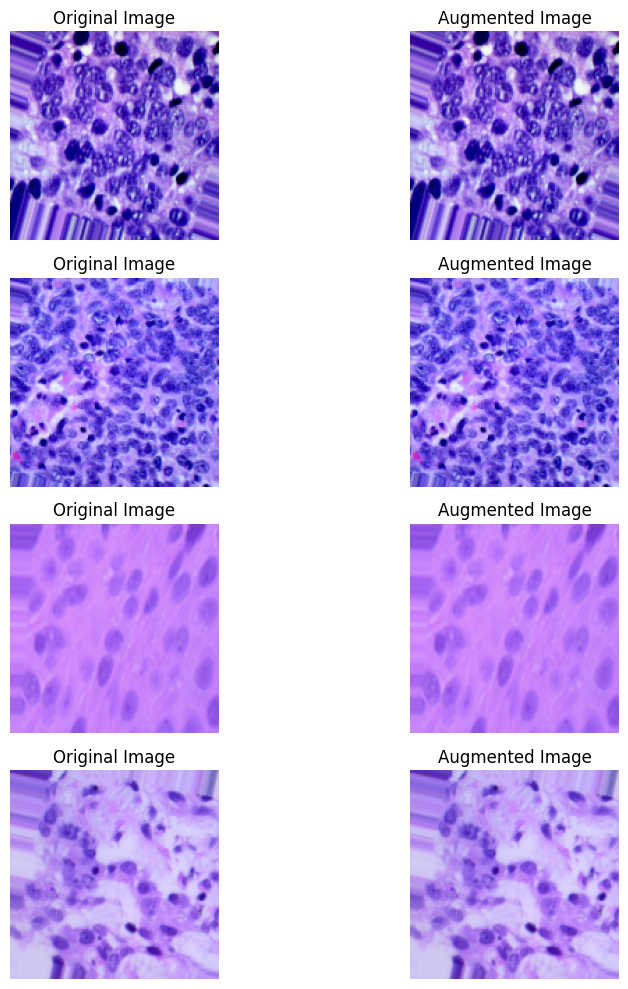

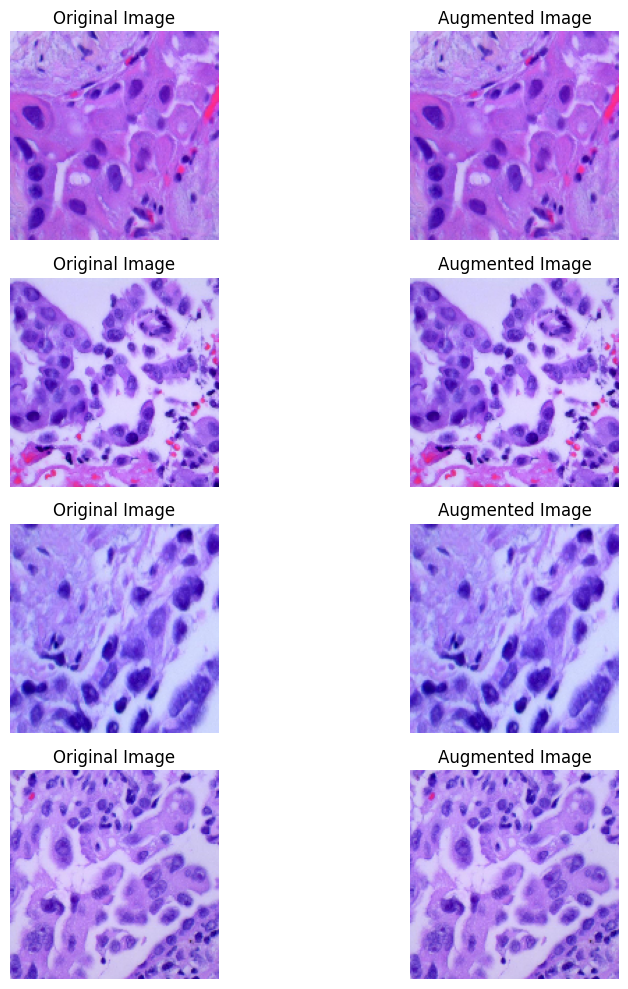

In [14]:
def display_images(generator, num_images=4):
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(num_images):
        img, label = next(generator)
        axs[2*i].imshow(img[0])
        axs[2*i].set_title('Original Image')
        axs[2*i].axis('off')

        axs[2*i+1].imshow(img[0])
        axs[2*i+1].set_title('Augmented Image')
        axs[2*i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Display original and augmented images for training data
display_images(train_generator)

# Display original and augmented images for validation data
display_images(validation_generator)

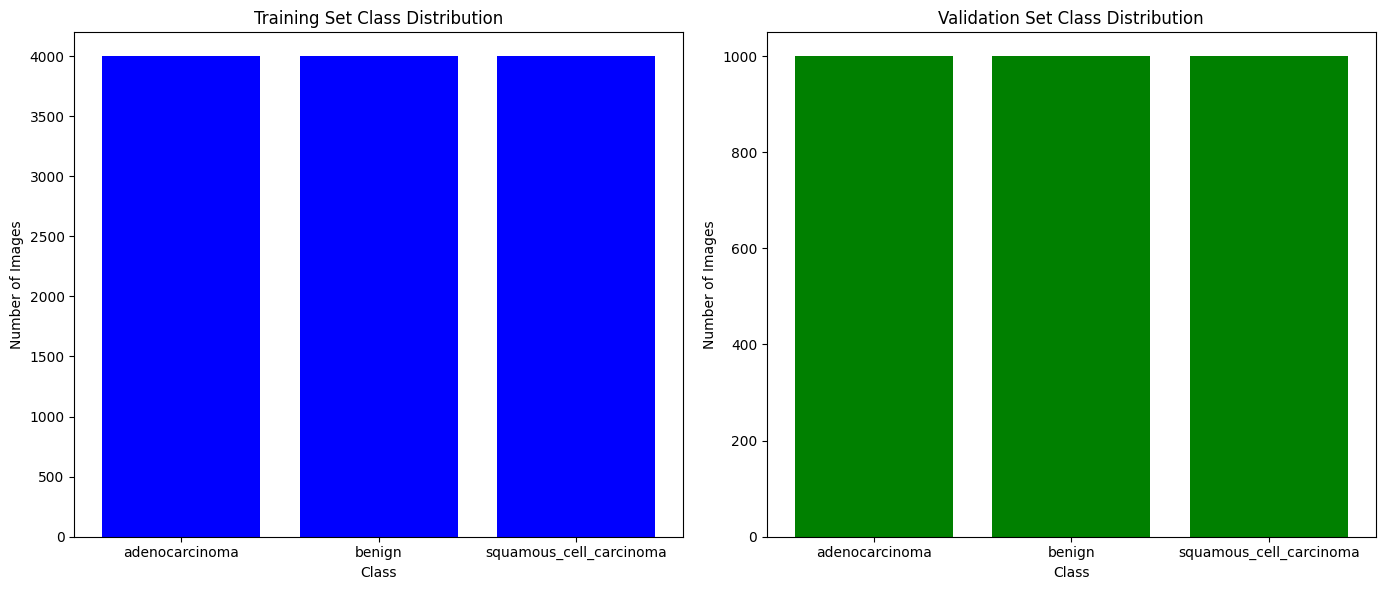

In [15]:
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Get the class labels
class_labels = list(train_class_indices.keys())

# Count the number of images per class in training and validation sets
train_counts = np.zeros(len(class_labels))
validation_counts = np.zeros(len(class_labels))

for i, label in enumerate(train_generator.classes):
    train_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    validation_counts[label] += 1

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(class_labels, train_counts, color='blue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

ax[1].bar(class_labels, validation_counts, color='green')
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [16]:
# Function to get image shapes
def get_image_shapes(generator):
    shapes = []
    for i in range(len(generator)):
        images, _ = generator[i]
        for img in images:
            shapes.append(img.shape)
    return np.array(shapes)

# Get shapes for training and validation sets
train_shapes = get_image_shapes(train_generator)
validation_shapes = get_image_shapes(validation_generator)

# Calculate statistics
def calculate_statistics(shapes):
    unique_shapes = np.unique(shapes, axis=0)
    min_dimensions = np.min(shapes, axis=0)
    max_dimensions = np.max(shapes, axis=0)
    mean_dimensions = np.mean(shapes, axis=0)
    return unique_shapes, min_dimensions, max_dimensions, mean_dimensions

train_unique_shapes, train_min_dimensions, train_max_dimensions, train_mean_dimensions = calculate_statistics(train_shapes)
validation_unique_shapes, validation_min_dimensions, validation_max_dimensions, validation_mean_dimensions = calculate_statistics(validation_shapes)

# Print statistics
print("Training Dataset:")
print(f"Number of images: {len(train_shapes)}")
print(f"Unique shapes: {train_unique_shapes}")
print(f"Min dimensions: {train_min_dimensions}")
print(f"Max dimensions: {train_max_dimensions}")
print(f"Mean dimensions: {train_mean_dimensions}")

print("\nValidation Dataset:")
print(f"Number of images: {len(validation_shapes)}")
print(f"Unique shapes: {validation_unique_shapes}")
print(f"Min dimensions: {validation_min_dimensions}")
print(f"Max dimensions: {validation_max_dimensions}")
print(f"Mean dimensions: {validation_mean_dimensions}")

Training Dataset:
Number of images: 12000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]

Validation Dataset:
Number of images: 3000
Unique shapes: [[150 150   3]]
Min dimensions: [150 150   3]
Max dimensions: [150 150   3]
Mean dimensions: [150. 150.   3.]


In [17]:
# Load the VGG19 model, excluding the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Adding multiple custom dense layers with batch normalization
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)  # Additional dense layer
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
predictions = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,213,763 (80.92 MB)

 Trainable params: 21,210,179 (80.91 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [19]:
# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [25]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 243s 636ms/step - accuracy: 0.9734 - loss: 0.0713 - val_accuracy: 0.9223 - val_loss: 0.1805
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 233s 617ms/step - accuracy: 0.9774 - loss: 0.0624 - val_accuracy: 0.9590 - val_loss: 0.1065
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 271s 640ms/step - accuracy: 0.9745 - loss: 0.0714 - val_accuracy: 0.9893 - val_loss: 0.0319


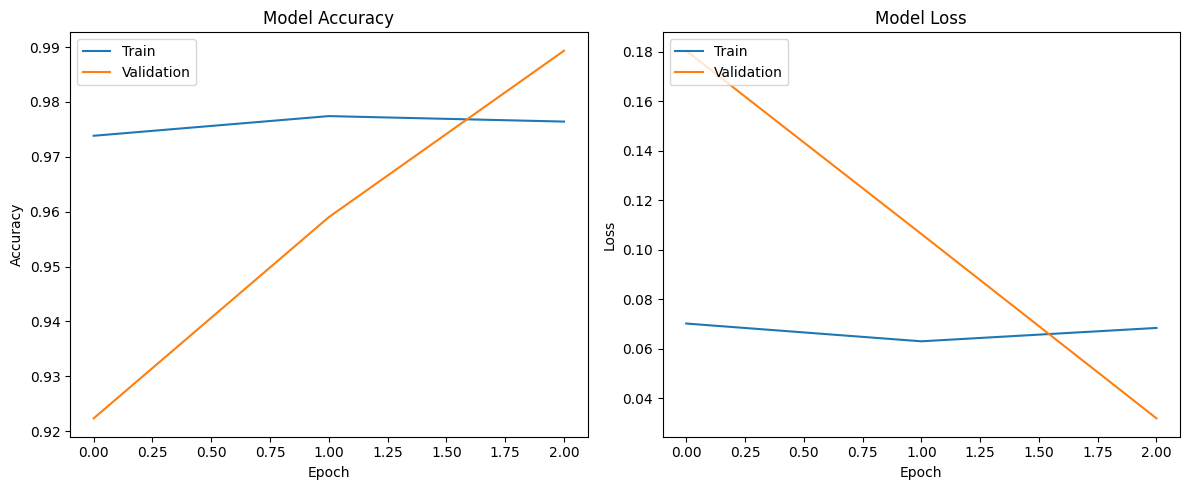

In [26]:
# Plot the training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [27]:
# Print final training and validation accuracy
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Final Training Accuracy: 0.9764
Final Validation Accuracy: 0.9893


In [28]:
# Evaluate the model on the validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

# Make predictions on the validation data
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the validation data
y_true = validation_generator.classes

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step


Confusion Matrix:


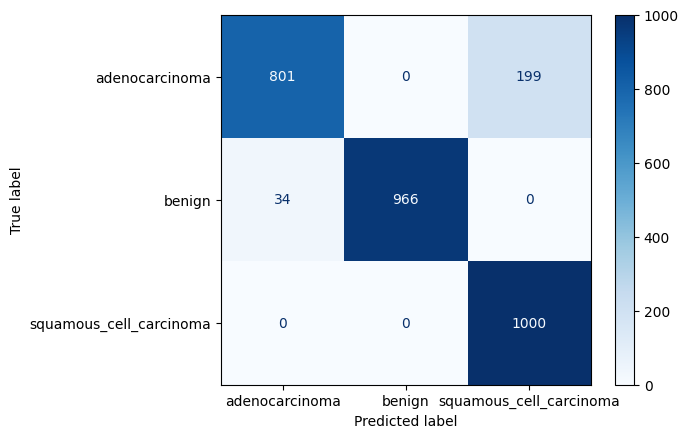

In [29]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print and visualize the confusion matrix
print("Confusion Matrix:")
class_names = list(validation_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [30]:
# Calculate recall
recall = recall_score(y_true, y_pred_classes, average='macro')
print(f"Recall: {recall:.4f}")

Recall: 0.9223


In [31]:
from sklearn.metrics import precision_score
# Calculate and print precision
precision = precision_score(y_true, y_pred_classes, average='macro')
print(f"Precision: {precision:.4f}")

Precision: 0.9311


In [32]:
# Save the trained model
try:
    model.save('lung_cancer_vgg19.h5')
    print("Model successfully saved as 'lung_cancer_vgg19.h5'")

    # Verify the file was created
    if os.path.exists('lung_cancer_vgg19.h5'):
        print(f"Verified: Model file exists at {os.path.abspath('lung_cancer_vgg19.h5')}")
        print(f"File size: {os.path.getsize('lung_cancer_vgg19.h5') / (1024*1024):.2f} MB")
except Exception as e:
    print(f"Error saving model: {e}")

Model successfully saved as 'lung_cancer_vgg19.h5'
Verified: Model file exists at /content/lung_cancer_vgg19.h5
File size: 242.92 MB
